In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import scipy.signal as signal
from torch.nn import functional as F

import warnings
warnings.filterwarnings("ignore")

In [241]:
from eeg_data_load import load_eeg_data

class_labels = [
    "Normal",
    "Complex_Partial_Seizures",
    "Electrographic_Seizures",
    "Video_detected_Seizures_with_no_visual_change_over_EEG",
]

train_path = "/kaggle/input/eeg-data-final/EEG_Data/train_data"
val_path = "/kaggle/input/eeg-data-final/EEG_Data/validation_data"

In [242]:
X_train, y_train = load_eeg_data(train_path, class_labels)
X_val, y_val = load_eeg_data(val_path, class_labels)

In [243]:
class EEGFrequencyEncoder(nn.Module):
    """Encodes EEG frequency band characteristics"""
    def __init__(self, sequence_length):
        super(EEGFrequencyEncoder, self).__init__()
        self.sequence_length = sequence_length
        
        # Frequency band-specific generators
        self.delta_gen = nn.Sequential(  # 0.5-4 Hz
            nn.Linear(20, sequence_length),
            nn.Tanh()
        )
        self.theta_gen = nn.Sequential(  # 4-8 Hz
            nn.Linear(20, sequence_length),
            nn.Tanh()
        )
        self.alpha_gen = nn.Sequential(  # 8-13 Hz
            nn.Linear(20, sequence_length),
            nn.Tanh()
        )
        self.beta_gen = nn.Sequential(   # 13-30 Hz
            nn.Linear(20, sequence_length),
            nn.Tanh()
        )
        self.gamma_gen = nn.Sequential(  # 30-100 Hz
            nn.Linear(20, sequence_length),
            nn.Tanh()
        )

    def forward(self, z):
        # Split input noise for different frequency bands
        z_split = torch.split(z, 20, dim=1)
        
        # Generate components for each frequency band
        delta = self.delta_gen(z_split[0])
        theta = self.theta_gen(z_split[1])
        alpha = self.alpha_gen(z_split[2])
        beta = self.beta_gen(z_split[3])
        gamma = self.gamma_gen(z_split[4])
        
        return delta, theta, alpha, beta, gamma

In [244]:
class PhysiologicalConstraints(nn.Module):
    """Applies physiological constraints to generated signals"""
    def __init__(self, sampling_rate=256):
        super(PhysiologicalConstraints, self).__init__()
        self.sampling_rate = sampling_rate
        
        # Define frequency bands
        self.freq_bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 100)
        }
        
    def apply_bandpass_filter(self, x, low_freq, high_freq):
        # Create Butterworth bandpass filter
        nyquist = self.sampling_rate / 2
        b, a = signal.butter(4, [low_freq/nyquist, high_freq/nyquist], btype='band')
        
        # Convert to numpy for filtering
        x_np = x.detach().cpu().numpy()
        x_filtered = signal.filtfilt(b, a, x_np, axis=-1)
        
        return torch.from_numpy(x_filtered).to(x.device)

    def forward(self, components):
        delta, theta, alpha, beta, gamma = components
        
        # Apply appropriate bandpass filters
        delta = self.apply_bandpass_filter(delta, *self.freq_bands['delta'])
        theta = self.apply_bandpass_filter(theta, *self.freq_bands['theta'])
        alpha = self.apply_bandpass_filter(alpha, *self.freq_bands['alpha'])
        beta = self.apply_bandpass_filter(beta, *self.freq_bands['beta'])
        gamma = self.apply_bandpass_filter(gamma, *self.freq_bands['gamma'])
        
        # Combine components with physiologically-inspired weights
        combined = (
            0.30 * delta +  # Delta waves are typically strongest
            0.25 * theta +
            0.20 * alpha +
            0.15 * beta +
            0.10 * gamma    # Gamma typically has lowest amplitude
        )
        
        return combined

In [245]:
class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim, num_classes, sequence_length, num_channels):
        super(ConditionalGenerator, self).__init__()
        
        self.sequence_length = sequence_length
        self.num_channels = num_channels
        self.label_embedding = nn.Embedding(num_classes, 50)  # Embed labels into 50-dim space
        
        # Combine noise and label embedding
        combined_dim = input_dim + 50
        
        self.fc = nn.Linear(combined_dim, 128 * (sequence_length // 4))
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(32, num_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embeddings = self.label_embedding(labels)
        combined_input = torch.cat([z, label_embeddings], dim=1)
        x = self.fc(combined_input)
        x = x.view(x.size(0), 128, -1)
        x = self.conv_blocks(x)
        return x


In [246]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, sequence_length, num_channels, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_channels)
        
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(num_channels * 2, 32, kernel_size=3, stride=1, padding=1),  # *2 for concatenated label
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.flat_size = 128 * (sequence_length // 4)
        
        self.fc = nn.Sequential(
            nn.Linear(self.flat_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Create label embeddings and reshape to match signal dimensions
        label_embeddings = self.label_embedding(labels)
        label_embeddings = label_embeddings.unsqueeze(2).repeat(1, 1, x.size(2))
        
        # Concatenate signal and label embeddings
        x = torch.cat([x, label_embeddings], dim=1)
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [247]:
def train_conditional_gan(generator, discriminator, dataloader, num_epochs, latent_dim, num_classes, device):
    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (real_data, real_labels) in enumerate(dataloader):
            batch_size = real_data.size(0)
            real_data, real_labels = real_data.to(device), real_labels.to(device)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)
            
            output_real = discriminator(real_data, real_labels)
            d_loss_real = criterion(output_real, label_real)
            
            # Generate fake data with matching labels
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            fake_data = generator(noise, fake_labels)
            output_fake = discriminator(fake_data.detach(), fake_labels)
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            output_fake = discriminator(fake_data, fake_labels)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

In [248]:
def generate_synthetic_samples(generator, num_samples, latent_dim, device, class_distribution=None):
    """
    Generate synthetic samples with corresponding labels
    
    Args:
        generator: Trained generator model
        num_samples: Number of samples to generate
        latent_dim: Dimension of noise vector
        device: torch device
        class_distribution: Optional list of class probabilities
    
    Returns:
        synthetic_data: Generated EEG signals
        synthetic_labels: Corresponding labels
    """
    generator.eval()
    with torch.no_grad():
        # Generate random noise
        noise = torch.randn(num_samples, latent_dim).to(device)
        
        # Generate labels according to desired distribution
        if class_distribution is None:
            # Uniform distribution across classes
            synthetic_labels = torch.randint(0, generator.num_classes, (num_samples,)).to(device)
        else:
            # Sample from specified distribution
            synthetic_labels = torch.tensor(
                np.random.choice(
                    len(class_distribution), 
                    size=num_samples, 
                    p=class_distribution
                )
            ).to(device)
        
        # Generate synthetic data
        synthetic_data = generator(noise, synthetic_labels)
        
    return synthetic_data.cpu(), synthetic_labels.cpu()

In [249]:
def evaluate_class_specific_metrics(real_data, real_labels, synthetic_data, synthetic_labels):
    """Evaluate quality of synthetic data for each class"""
    unique_classes = torch.unique(real_labels)
    metrics = {}
    
    for class_idx in unique_classes:
        # Get real and synthetic samples for this class
        real_class_data = real_data[real_labels == class_idx]
        synth_class_data = synthetic_data[synthetic_labels == class_idx]
        
        # Calculate metrics
        metrics[f'class_{class_idx}'] = {
            'wasserstein_distance': wasserstein_distance(
                real_class_data.flatten(), 
                synth_class_data.flatten()
            ),
            'real_mean': torch.mean(real_class_data).item(),
            'synthetic_mean': torch.mean(synth_class_data).item(),
            'real_std': torch.std(real_class_data).item(),
            'synthetic_std': torch.std(synth_class_data).item(),
            'num_real_samples': len(real_class_data),
            'num_synthetic_samples': len(synth_class_data)
        }
    
    return metrics

In [250]:
sequence_length = 500
num_channels = 19
num_classes = 4
batch_size = 32
num_epochs = 100
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [251]:
generator = ConditionalGenerator(latent_dim, num_classes, sequence_length, num_channels).to(device)
discriminator = ConditionalDiscriminator(sequence_length, num_channels, num_classes).to(device)

In [252]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [253]:
real_data, real_labels = X_train_tensor, y_train_tensor
dataset = TensorDataset(real_data, real_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [254]:
train_conditional_gan(generator, discriminator, dataloader, num_epochs, latent_dim, num_classes, device)

Epoch [10/100], d_loss: 0.0100, g_loss: 6.2072
Epoch [20/100], d_loss: 0.0000, g_loss: 15.5056
Epoch [30/100], d_loss: 0.0007, g_loss: 10.7823
Epoch [40/100], d_loss: 0.0004, g_loss: 11.1526
Epoch [50/100], d_loss: 0.0001, g_loss: 11.2556
Epoch [60/100], d_loss: 0.0002, g_loss: 14.6099
Epoch [70/100], d_loss: 0.0000, g_loss: 14.2137
Epoch [80/100], d_loss: 0.0000, g_loss: 13.5655
Epoch [90/100], d_loss: 0.0001, g_loss: 11.0434
Epoch [100/100], d_loss: 0.0000, g_loss: 15.1378


In [255]:
unique_values, counts = np.unique(y_train, return_counts=True)

percentages = (counts / y_train.size)

print("Percentages:", percentages)

type(percentages.tolist())

Percentages: [0.49625535 0.39158345 0.0971826  0.0149786 ]


list

In [330]:
class_distribution =  percentages.tolist() 
synthetic_data, synthetic_labels = generate_synthetic_samples(
        generator, 2000, latent_dim, device, class_distribution
    )

In [331]:
import pandas as pd

metrics = evaluate_class_specific_metrics(X_train_tensor, real_labels, synthetic_data, synthetic_labels)

table_data = []
for class_name, metrics_dict in metrics.items():
    row = {
        'Class': class_name,
        'Wasserstein Distance': round(metrics_dict['wasserstein_distance'], 4),
        'Real Mean': round(metrics_dict['real_mean'], 4),
        'Synthetic Mean': round(metrics_dict['synthetic_mean'], 4),
        'Real Std': round(metrics_dict['real_std'], 4),
        'Synthetic Std': round(metrics_dict['synthetic_std'], 4),
        'Num Real Samples': metrics_dict['num_real_samples'],
        'Num Synthetic Samples': metrics_dict['num_synthetic_samples']
    }
    table_data.append(row)

df = pd.DataFrame(table_data)

print(df)

     Class  Wasserstein Distance  Real Mean  Synthetic Mean  Real Std  \
0  class_0                0.9139    -0.0000          0.2090    0.0166   
1  class_1                0.9487     0.0000          0.1502    0.0320   
2  class_2                0.8805     0.0001         -0.1372    0.0205   
3  class_3                0.8933     0.0000          0.1009    0.0264   

   Synthetic Std  Num Real Samples  Num Synthetic Samples  
0         0.9169              2783                    972  
1         0.9609              2196                    795  
2         0.9050               545                    202  
3         0.9235                84                     31  


Training and Evaluation of the Model

In [332]:
synthetic_data.shape, type(synthetic_data)

(torch.Size([2000, 19, 500]), torch.Tensor)

In [333]:
synthetic_data = synthetic_data.numpy()

In [354]:
from advanced_feature_extractor import EEGFeatureExtractor

extractor = EEGFeatureExtractor(synthetic_data)
synthetic_data_features = extractor.combine_features()

In [355]:
synthetic_data_features.shape

(2000, 950)

In [356]:
X_val = np.load('/kaggle/input/features/X_val.npy')
y_val = np.load('/kaggle/input/features/y_val.npy')

In [357]:
real_data = np.load('/kaggle/input/features/X_train.npy')
real_data = torch.tensor(real_data, dtype=torch.float32)

In [358]:
synthetic_data_tensor = torch.tensor(synthetic_data_features, dtype=torch.float32)
synthetic_labels_tensor = torch.tensor(synthetic_labels, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [360]:
train_dataset = TensorDataset(synthetic_data_tensor, synthetic_labels_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [361]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [362]:
from model_utility_script import EEGClassifier

input_size = synthetic_data_features.shape[1]
model = EEGClassifier(input_size=input_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [363]:
from tqdm import tqdm 


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    # Check if CUDA is available on Kaggle and select the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model to the selected device (GPU or CPU)
    model = model.to(device)
    
    best_val_acc = 0
    best_model = None
    training_losses = []
    validation_losses = []
    
    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            epoch_train_loss = 0
            
            train_loader_tqdm = tqdm(train_loader, 
                                   desc=f"Epoch {epoch+1}/{num_epochs} - Training",
                                   leave=False,  # Don't leave the progress bar
                                   position=0,   # Fix the position
                                   ncols=100)    # Fix the width
            
            for inputs, labels in train_loader_tqdm:
                # Move inputs and labels to the GPU (or CPU if no GPU is available)
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_train_loss += loss.item()
                train_loader_tqdm.set_postfix({'loss': f'{loss.item():.4f}'}, refresh=True)
            
            avg_train_loss = epoch_train_loss / len(train_loader)
            training_losses.append(avg_train_loss)
            
            # Validation phase
            model.eval()
            epoch_val_loss = 0
            val_preds = []
            val_labels = []
            
            with torch.no_grad():
                val_loader_tqdm = tqdm(val_loader, 
                                     desc=f"Epoch {epoch+1}/{num_epochs} - Validation",
                                     leave=False,  # Don't leave the progress bar
                                     position=0,   # Fix the position
                                     ncols=100)    # Fix the width
                
                for inputs, labels in val_loader_tqdm:
                    # Move inputs and labels to the GPU (or CPU if no GPU is available)
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    epoch_val_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_preds.extend(predicted.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())
                    val_loader_tqdm.set_postfix({'loss': f'{loss.item():.4f}'}, refresh=True)
            
            avg_val_loss = epoch_val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            
            # Print epoch summary on a new line
            val_acc = balanced_accuracy_score(val_labels, val_preds)
            print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}')
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model.state_dict().copy()
                print(f'New best model saved with validation accuracy: {val_acc:.4f}')
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Saving best model...")
    
    finally:
        # Plot training curves
        plt.figure(figsize=(10, 6))
        plt.plot(training_losses, label='Training Loss')
        plt.plot(validation_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        if best_model is not None:
            model.load_state_dict(best_model)
    
    return model, training_losses, validation_losses

Epoch 1: Train Loss = 0.5712, Val Loss = 0.1444, Val Acc = 0.9385
New best model saved with validation accuracy: 0.9385


Epoch 2: Train Loss = 0.4193, Val Loss = 0.1070, Val Acc = 0.9660
New best model saved with validation accuracy: 0.9660


Epoch 3: Train Loss = 0.3828, Val Loss = 0.1192, Val Acc = 0.9449


Epoch 4: Train Loss = 0.3632, Val Loss = 0.1083, Val Acc = 0.9613


Epoch 5: Train Loss = 0.3443, Val Loss = 0.1030, Val Acc = 0.9452


Epoch 6: Train Loss = 0.3385, Val Loss = 0.0668, Val Acc = 0.9751
New best model saved with validation accuracy: 0.9751


Epoch 7: Train Loss = 0.3358, Val Loss = 0.0827, Val Acc = 0.9821
New best model saved with validation accuracy: 0.9821


Epoch 8: Train Loss = 0.3258, Val Loss = 0.0886, Val Acc = 0.9791


Epoch 9: Train Loss = 0.3282, Val Loss = 0.0665, Val Acc = 0.9757


Epoch 10: Train Loss = 0.3115, Val Loss = 0.0741, Val Acc = 0.9759


Epoch 11: Train Loss = 0.3118, Val Loss = 0.0678, Val Acc = 0.9750


Epoch 12: Train Loss = 0.3113, Val Loss = 0.0615, Val Acc = 0.9738


Epoch 13: Train Loss = 0.3053, Val Loss = 0.0616, Val Acc = 0.9763


Epoch 14: Train Loss = 0.3071, Val Loss = 0.0635, Val Acc = 0.9770


Epoch 15: Train Loss = 0.3135, Val Loss = 0.0524, Val Acc = 0.9769


Epoch 16: Train Loss = 0.3106, Val Loss = 0.0619, Val Acc = 0.9780


Epoch 17: Train Loss = 0.2984, Val Loss = 0.0742, Val Acc = 0.9757


Epoch 18: Train Loss = 0.3071, Val Loss = 0.0701, Val Acc = 0.9641


Epoch 19: Train Loss = 0.3045, Val Loss = 0.0606, Val Acc = 0.9767


Epoch 20: Train Loss = 0.2990, Val Loss = 0.0681, Val Acc = 0.9625


Epoch 21: Train Loss = 0.2982, Val Loss = 0.0551, Val Acc = 0.9783


Epoch 22: Train Loss = 0.2983, Val Loss = 0.0532, Val Acc = 0.9779


Epoch 23: Train Loss = 0.2966, Val Loss = 0.0614, Val Acc = 0.9776


Epoch 24: Train Loss = 0.2921, Val Loss = 0.0665, Val Acc = 0.9749


Epoch 25: Train Loss = 0.2884, Val Loss = 0.0554, Val Acc = 0.9779


Epoch 26: Train Loss = 0.2978, Val Loss = 0.0614, Val Acc = 0.9539


Epoch 27: Train Loss = 0.2990, Val Loss = 0.0676, Val Acc = 0.9889
New best model saved with validation accuracy: 0.9889


Epoch 28: Train Loss = 0.2881, Val Loss = 0.0518, Val Acc = 0.9785


Epoch 29: Train Loss = 0.2864, Val Loss = 0.0678, Val Acc = 0.9707


Epoch 30: Train Loss = 0.2887, Val Loss = 0.0627, Val Acc = 0.9774


Epoch 31: Train Loss = 0.2860, Val Loss = 0.0813, Val Acc = 0.9786


Epoch 32: Train Loss = 0.2905, Val Loss = 0.0774, Val Acc = 0.9748


Epoch 33: Train Loss = 0.2907, Val Loss = 0.0662, Val Acc = 0.9727


Epoch 34: Train Loss = 0.2847, Val Loss = 0.1044, Val Acc = 0.9681


Epoch 35: Train Loss = 0.2820, Val Loss = 0.0723, Val Acc = 0.9654


Epoch 36: Train Loss = 0.2853, Val Loss = 0.0525, Val Acc = 0.9793


Epoch 37: Train Loss = 0.2847, Val Loss = 0.0645, Val Acc = 0.9764


Epoch 38: Train Loss = 0.2909, Val Loss = 0.0599, Val Acc = 0.9758


Epoch 39: Train Loss = 0.2844, Val Loss = 0.0556, Val Acc = 0.9883


Epoch 40: Train Loss = 0.2849, Val Loss = 0.0658, Val Acc = 0.9760


Epoch 41: Train Loss = 0.2860, Val Loss = 0.0590, Val Acc = 0.9783


Epoch 42: Train Loss = 0.2880, Val Loss = 0.0576, Val Acc = 0.9783


Epoch 43: Train Loss = 0.2851, Val Loss = 0.0707, Val Acc = 0.9637


Epoch 44: Train Loss = 0.2822, Val Loss = 0.0834, Val Acc = 0.9731


Epoch 45: Train Loss = 0.2786, Val Loss = 0.0591, Val Acc = 0.9788


Epoch 46: Train Loss = 0.2836, Val Loss = 0.0616, Val Acc = 0.9789


Epoch 47: Train Loss = 0.2747, Val Loss = 0.0639, Val Acc = 0.9805


Epoch 48: Train Loss = 0.2794, Val Loss = 0.0651, Val Acc = 0.9788


Epoch 49: Train Loss = 0.2764, Val Loss = 0.1317, Val Acc = 0.9660


Epoch 50: Train Loss = 0.2859, Val Loss = 0.1033, Val Acc = 0.9696


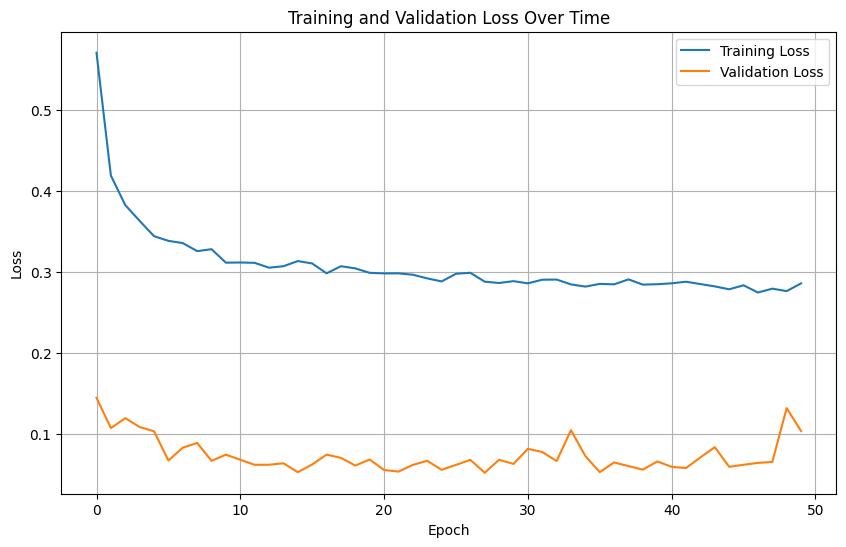

In [364]:
model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer)


In [365]:
def evaluate_model(model, test_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] 
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Get predictions and probabilities
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.softmax(outputs, dim=1)
            
            # Collect the results
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate the classification report and balanced accuracy
    classification_report_result = classification_report(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    
    # Compute the AUC-ROC score for multi-class classification (One-vs-Rest)
    auc_roc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')

    # Print the outputs
    print("Classification Report:\n", classification_report_result)
    print("Balanced Accuracy:", balanced_accuracy)
    print("AUC-ROC Score:", auc_roc)
    
    return {
        'classification_report': classification_report_result,
        'balanced_accuracy': balanced_accuracy,
        'auc_roc': auc_roc
    }

results = evaluate_model(model, val_loader, num_classes=4)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       696
           1       0.98      0.99      0.98       549
           2       0.99      0.96      0.97       137
           3       1.00      0.95      0.98        21

    accuracy                           0.98      1403
   macro avg       0.99      0.97      0.98      1403
weighted avg       0.98      0.98      0.98      1403

Balanced Accuracy: 0.969552196310917
AUC-ROC Score: 0.9971428730067373
